# Create instances of Data from Gaussian mocks

In [1]:
import time

import numpy as np
from scipy import optimize as opt
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams.update({'font.size': 14})

from cosmoprimo import *
from pycorr import TwoPointCorrelationFunction
from pypower import CatalogMesh, ArrayMesh
from pypower.fft_power import project_to_basis
from mockfactory import EulerianLinearMock, LagrangianLinearMock, RandomBoxCatalog, setup_logging

from densitysplit import catalog_data, density_split
from bin.density_split_mocks_functions import damping_function
from densitysplit.pk_model import *
from densitysplit.utils import *
from densitysplit.corr_func_utils import *
from densitysplit.split_model import *

## Cosmology

In [2]:
z = 1.175

# Abacus summit base cosmology
cosmo_abacus = fiducial.AbacusSummitBase()
bg = cosmo_abacus.get_background()

k=np.logspace(-5, 3, 100000)

## Data and output directories

In [32]:
data_dir = '/feynman/work/dphp/mp270220/data/'
output_dir = '/feynman/work/dphp/mp270220/outputs/mocks/gaussian/'

In [159]:
xi_list = list()
s = np.load('/feynman/work/dphp/mp270220/outputs/mocks/AbacusSummit_1Gpc_z1.175_10_gaussianMocks_truncatedPk_nbarx5_xi_from_delta_r_sep.npy')

for i in range(10):
    xi = np.load('/feynman/work/dphp/mp270220/outputs/mocks/AbacusSummit_1Gpc_z1.175'+'_gaussianMock{}_truncatedPk_nbarx5_xi_from_delta_r.npy'.format(i))
    xi_list.append(xi)
    
xi_FFT_delta_r = np.array(xi_list)

In [160]:
xi_FFT_particles = np.load(output_dir+'AbacusSummit_1Gpc_z1.175'+'_10_gaussianMocks_truncatedPk_nbarx5_cellsize10_estimated2PCF.npy')

## Model

In [161]:
kN = np.pi*512/1000

In [162]:
pklin = cosmo_abacus.get_fourier().pk_interpolator(extrap_kmin=1e-6, extrap_kmax=1e3).to_1d(z)
pklin_array = pklin(k)
pkdamped_func = lambda k: pklin(k) * np.array([damping_function(kk) for kk in k])
pkdamped = PowerSpectrumInterpolator1D.from_callable(k, pkdamped_func)

In [163]:
model = SplitCCFModel(k, redshift=z, cosmology=cosmo_abacus, bias=1.8, nsplits=1, shot_noise=404.21317620515566)
model.set_pk_model(pk=pkdamped)

In [164]:
ells = [0]
nells = len(ells)

In [165]:
poles_FFT_delta_r = np.mean(xi_FFT_delta_r, axis=0)
xiell_FFT_delta_r = poles_FFT_delta_r.reshape((nells, len(poles_FFT_delta_r)//nells))
cov_FFT_delta_r = np.cov(xi_FFT_delta_r, rowvar=False)
std_FFT_delta_r = np.array(np.array_split(np.diag(cov_FFT_delta_r)**0.5, nells))/np.sqrt(10)

In [166]:
poles_FFT_particles = np.mean(xi_FFT_particles, axis=0)
xiell_FFT_particles = poles_FFT_particles.reshape((nells, len(poles_FFT_particles)//nells))
cov_FFT_particles = np.cov(xi_FFT_particles, rowvar=False)
std_FFT_particles = np.array(np.array_split(np.diag(cov_FFT_particles)**0.5, nells))/np.sqrt(10)

In [172]:
mocks_results = np.load('/feynman/work/dphp/mp270220/outputs/'+'AbacusSummit_1Gpc_z1.175'+'_10_gaussianMocks_truncatedPk_nbarx5_cellsize10_2PCF.npy', allow_pickle=True)
mocks_xiell, mocks_cov = get_poles(mocks_results, ells)
mocks_std = np.array(np.array_split(np.diag(mocks_cov)**0.5, nells))/np.sqrt(10)
mocks_s, _, res = mocks_results[0].get_corr(return_sep=True)

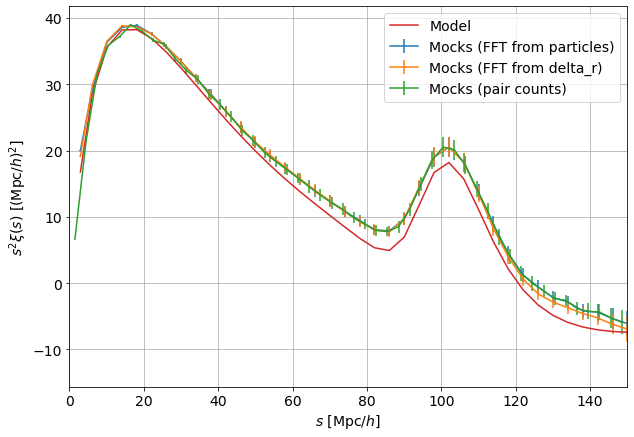

In [168]:
plt.rcParams["figure.figsize"] = (10, 7)

for ill, ell in enumerate(ells):
    plt.errorbar(s, s**2 * xiell_FFT_particles[ill], s**2 * std_FFT_particles[ill], fmt='-', label = r'Mocks (FFT from particles)')
    plt.errorbar(s, s**2 * xiell_FFT_delta_r[ill], s**2 * std_FFT_delta_r[ill], fmt='-', label = r'Mocks (FFT from delta_r)')
    plt.errorbar(mocks_s, mocks_s**2 * mocks_xiell[ill], mocks_s**2 * mocks_std[ill], fmt='-', label = r'Mocks (pair counts)')
    plt.plot(s, s**2 * model.xi(s), label = 'Model', ls='-')
    plt.grid(True)

plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
plt.ylabel(r'$s^2 \xi(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.xlim((0, 150))
plt.legend()
plt.show()